## Imports

In [1]:

import numpy as np
import math
from fractions import Fraction
import itertools

## Constants

In [21]:
#CONSTANT

pyt_comma = 0.0136432
peaks = [2.4, 6.5, 11.4, 18.8, 29, 33.6]
round_peaks = [int(i) for i in peaks]

#planet ratios
Schumann_earth = [7.83, 14.3, 20.8, 27.3, 33.8]
Mercury = 141.27

## Functions

### Utilities

In [6]:
def rebound(x, low = 1, high = 2, octave = 2):
    while x > high:
        x = x/octave
    while x < low:
        x = x*octave
    return x

def nth_root (num, root):
    answer = num**(1/root)
    return answer


#Function that compares lists (i.e. peak harmonics)
def compareLists(list1, list2, bounds):
    matching = []
    matching_pos = []
    for i, l1 in enumerate(list1):
        for j, l2 in enumerate(list2):
            if l2-bounds < l1 < l2+bounds:
                matching.append((l1+l2)/2)
                matching_pos.append([(l1+l2)/2, i+1, j+1])
    matching = np.array(matching)
    matching_pos = np.array(matching_pos)
    ratios_temp = []
    for i in range(len(matching_pos)):
        if matching_pos[i][1]>matching_pos[i][2]:
            ratios_temp.append(matching_pos[i][1]/matching_pos[i][2])
            #print(matching_pos[i][0])
        else:
            ratios_temp.append(matching_pos[i][2]/matching_pos[i][1])
    matching_pos_ratios = np.array(ratios_temp)
    return matching, matching_pos, matching_pos_ratios

In [11]:
a, b, c = compareLists([4, 4.8, 5.8], [5.8, 4, 8, 10], 0.1)
b

array([[4. , 1. , 2. ],
       [5.8, 3. , 1. ]])

### Peak ratios and Harmonics

In [12]:
#This function calculates the 15 ratios (with the possibility to bound them between 1 and 2) derived from the 6 peaks
def compute_peak_ratios(peaks, rebound = 1, octave = 2):
    ratios = []
    peak_ratios_rebound = []
    for p1 in peaks:
        for p2 in peaks:
            ratio_temp = p2/p1
            if ratio_temp == 1:
                ratio_temp = None
            elif ratio_temp < 1:
                ratio_temp = None

            ratios.append(ratio_temp)

        peak_ratios = np.array(ratios)
        peak_ratios = [i for i in peak_ratios if i]
        peak_ratios = list(set(peak_ratios))
    if rebound == 1:
        for peak in peak_ratios:
            while peak > octave:
                peak = peak/octave
            peak_ratios_rebound.append(peak)
    peak_ratios_rebound = np.array(peak_ratios_rebound)
    peak_ratios_rebound = [i for i in peak_ratios_rebound if i]
    peak_ratios = sorted(peak_ratios)
    peak_ratios_rebound = sorted(list(set(peak_ratios_rebound)))
    return peak_ratios, peak_ratios_rebound

In [33]:
#This function takes a list of frequency peaks as input and computes the desired number of harmonics
#with the formula: x + 2x + 3x ... + nx
def EEG_harmonics_mult(peaks, n_harmonics, n_oct_up = 0):
    n_harmonics = n_harmonics + 2
    multi_harmonics = []
    multi_harmonics_rebound = []
    for p in peaks:
        multi_harmonics_r = []
        multi_harm_temp = []
        harmonics = []
        p = p * (2**n_oct_up)
        i = 1
        harm_temp = p
        while i < n_harmonics:
            harm_temp = p * i
            harmonics.append(harm_temp)
            i+=1
        multi_harmonics.append(harmonics)
    multi_harmonics = np.array(multi_harmonics)  
        
    return multi_harmonics

#This function takes a list of frequency peaks as input and computes the desired number of harmonics
#with the formula: x + x/2 + x/3 ... + x/n
def EEG_harmonics_div(peaks, n_harmonics, n_oct_up = 0):
    n_harmonics = n_harmonics + 2
    multi_harmonics = []
    multi_harmonics_sub = []
    for p in peaks:
                           
        harmonics = [] 
        harmonics_sub = []
        p = p * (2**n_oct_up)               
        i = 2
        harm_temp = p
        harm_temp_sub = p
        while i < n_harmonics:
            harm_temp = harm_temp + (p/i)
            harm_temp_sub = abs(harm_temp_sub - (p/i))
            harmonics.append(harm_temp)
            harmonics_sub.append(harm_temp_sub)
            i+=1    
        multi_harmonics.append(harmonics)
        multi_harmonics_sub.append(harmonics_sub)
    multi_harmonics = np.array(multi_harmonics)
    multi_harmonics_bounded = multi_harmonics.copy()
    multi_harmonics_sub = np.array(multi_harmonics_sub)
    multi_harmonics_sub_bounded = multi_harmonics_sub.copy()
    #Rebound the result between 1 and 2
    for i in range(len(multi_harmonics_bounded)):
        for j in range(len(multi_harmonics_bounded[0])):
            multi_harmonics_bounded[i][j] = rebound(multi_harmonics_bounded[i][j])
            multi_harmonics_sub_bounded[i][j] = rebound(multi_harmonics_sub_bounded[i][j])
    return multi_harmonics, multi_harmonics_bounded, multi_harmonics_sub, multi_harmonics_sub_bounded


def harmonic_fit(peak_bands = [0, 1, 2, 3, 4, 5], n_harm = 10, bounds = 1, function = 'mult', peaks = peaks):
    from itertools import combinations
    if function == 'mult':
        multi_harmonics = EEG_harmonics_mult(peaks, n_harm)
    elif function == 'div':
        multi_harmonics, x, y, z = EEG_harmonics_div(peaks, n_harm)
    #print(multi_harmonics)
    list_peaks = list(combinations(peak_bands,2))
    print(list_peaks)
    harm_temp = []
    for i in range(len(list_peaks)):
        harms, b, c = compareLists(multi_harmonics[list_peaks[i][0]], multi_harmonics[list_peaks[i][1]], bounds)  
        harm_temp.append(harms)
    harm_fit = np.array(harm_temp).squeeze()

    if len(peak_bands) > 2:
        harm_fit = list(itertools.chain.from_iterable(harm_fit))

    return harm_fit

In [37]:
harmonic_fitting = harmonic_fit([0, 1, 2, 3, 4, 5], 75, 0.05, 'mult')
harmonic_fitting


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


[156.0,
 45.6,
 91.2,
 136.8,
 182.4,
 112.80000000000001,
 33.6,
 67.2,
 100.80000000000001,
 134.4,
 168.0,
 377.0,
 638.4]

In [38]:
h, i = compute_peak_ratios(peaks, 1, 2)
i

[1.1153846153846154,
 1.1586206896551725,
 1.1875,
 1.2719298245614035,
 1.2923076923076924,
 1.3541666666666667,
 1.4461538461538461,
 1.4736842105263157,
 1.5104166666666667,
 1.5425531914893615,
 1.6491228070175439,
 1.7500000000000002,
 1.7538461538461538,
 1.7872340425531914,
 1.9583333333333335]

In [50]:

z, charm_fit = compute_peak_ratios(harmonic_fit([0, 1, 2, 3, 4, 5], 65, 0.1, 'mult'))
charm_fit

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


[1.0178571428571428,
 1.023076923076923,
 1.0334429824561404,
 1.105263157894737,
 1.119047619047619,
 1.1403508771929824,
 1.1607142857142856,
 1.1666666666666665,
 1.1875,
 1.1914893617021276,
 1.2083333333333333,
 1.2127659574468086,
 1.236842105263158,
 1.3333333333333333,
 1.3571428571428572,
 1.377923976608187,
 1.3829787234042552,
 1.4025297619047619,
 1.4148936170212765,
 1.4736842105263157,
 1.5,
 1.5476190476190474,
 1.583333333333333,
 1.6710992907801416,
 1.6785714285714286,
 1.693368700265252,
 1.7105263157894737,
 1.7499999999999998,
 1.8700396825396823,
 2.0]

In [9]:
mh, mh_bound, mh_sub, mh_sub_bound = EEG_harmonics_div(peaks, 10, n_oct_up = 0)
mh
#div_harmonics = compareLists(mh[5], mh[4], 0.01)
#div_harmonics

array([[  3.6       ,   4.4       ,   5.        ,   5.48      ,
          5.88      ,   6.22285714,   6.52285714,   6.78952381,
          7.02952381,   7.24770563],
       [ 13.05      ,  15.95      ,  18.125     ,  19.865     ,
         21.315     ,  22.55785714,  23.64535714,  24.61202381,
         25.48202381,  26.2729329 ],
       [ 17.1       ,  20.9       ,  23.75      ,  26.03      ,
         27.93      ,  29.55857143,  30.98357143,  32.2502381 ,
         33.3902381 ,  34.42660173],
       [ 28.2       ,  34.46666667,  39.16666667,  42.92666667,
         46.06      ,  48.74571429,  51.09571429,  53.18460317,
         55.06460317,  56.77369408],
       [ 43.5       ,  53.16666667,  60.41666667,  66.21666667,
         71.05      ,  75.19285714,  78.81785714,  82.04007937,
         84.94007937,  87.576443  ],
       [ 50.4       ,  61.6       ,  70.        ,  76.72      ,
         82.32      ,  87.12      ,  91.32      ,  95.05333333,
         98.41333333, 101.46787879]])

In [56]:
#Compute peaks interval of consonant harmonics
compute_consonance (charm_fit, 0.2)

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


([0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.2361111111111111,
  0.8333333333333334,
  0.26785714285714285,
  0.5833333333333334,
  0.5833333333333334],
 [[1.6785714285714286, 1.119047619047619],
  [1.7105263157894737, 1.1403508771929824],
  [1.7499999999999998, 1.1666666666666665],
  [1.5, 1.3333333333333333],
  [2.0, 1.3333333333333333],
  [1.1875, 1.3571428571428572],
  [1.1607142857142856, 1.5476190476190474],
  [1.5, 2.0]])

### n-TET 

In [40]:


def oct_subdiv(ratio,bounds,octave,n):    
    Octdiv, Octvalue, i = [], [], 1
    ratios = []
    while len(Octdiv) < n:
        ratio_mult = (ratio**i)
        while ratio_mult > octave:
            ratio_mult = ratio_mult/octave    
            
        rescale_ratio = ratio_mult - round(ratio_mult)
        ratios.append(ratio_mult)
        i+=1
        if -bounds < rescale_ratio < bounds:
            Octdiv.append(i-1)
            Octvalue.append(ratio_mult)
        else:
            continue
    return Octdiv, Octvalue, ratios


def compare_octave_division(Octdiv = 53, Octdiv2 = 12, bounds = 0.01, octave = 2):
    ListOctdiv = []
    ListOctdiv2 = []
    OctdivSum = 1
    OctdivSum2 = 1
    i = 1
    i2 = 1
    Matching_harmonics = []
    #HARMONIC_RATIOS = [1, 1.0595, 1.1225, 1.1892, 1.2599, 1.3348, 1.4142, 1.4983, 1.5874, 1.6818, 1.7818, 1.8897]
    while OctdivSum < octave:
        OctdivSum =(nth_root(octave, Octdiv))**i
        i+=1
        ListOctdiv.append(OctdivSum)
    #print(ListOctdiv)

    while OctdivSum2 < octave:
        OctdivSum2 =(nth_root(octave, Octdiv2))**i2
        i2+=1
        ListOctdiv2.append(OctdivSum2)
    #print(ListOctdiv2)
    for i, n in enumerate(ListOctdiv):
        for j, harm in enumerate(ListOctdiv2):
            if harm-bounds < n < harm+bounds:
                Matching_harmonics.append([n, i+1, harm, j+1])
    Matching_harmonics = np.array(Matching_harmonics)
    return Matching_harmonics




### Consonance

In [41]:
#Oct_subdiv
#Argument 1 : a ratio in the form of a float or a fraction
#Argument 2 : bounds between which the octave should fall
#Argument 3 : value of the octave
#Argument 4 : number of octave subdivisions
def compute_consonance (peaks, limit):
    consonance_ = []
    peaks2keep = []
    peaks_consonance = []
    for p1 in peaks:    
        for p2 in peaks:
            peaks2keep_temp = []
            p2x = p2
            p1x = p1
            cons_temp = (p2x/p1x).as_integer_ratio()
            cons_temp = (cons_temp[0] + cons_temp[1])/(cons_temp[0] * cons_temp[1])
            #print(cons_temp)
            if cons_temp == 2:
                cons_temp = None
                p2x = None
                p1x = None
            elif cons_temp < limit:
                cons_temp = None
                p2x = None
                p1x = None
            if p2x != None:
                peaks2keep_temp.extend([p2x, p1x])
            consonance_.append(cons_temp)  
            peaks2keep.append(peaks2keep_temp)
        peaks_consonance = np.array(peaks2keep)
        peaks_consonance = [x for x in peaks_consonance if x]
        consonance = np.array(consonance_)
        consonance = [i for i in consonance if i]
        #consonance = list(set(consonance))
    return consonance, peaks_consonance

# Function that computes integer ratios from peaks with higher consonance
# Needs at least two pairs of values
def comp_consonant_integers_ratios (peaks_consonance):
    cons_integer = []
    for i in range(len(peaks_consonance)):
        #for j in range(len(peaks_consonance[0])):
        a = peaks_consonance[i][0]
        b = peaks_consonance[i][1]
        if a > b:
            while a > (b):
                a = a/2
        if a < b:
            while b > (a):
                b = b/2
        c = a/b
        cons_temp = (c).as_integer_ratio()
        #print(cons_temp)
        cons_integer.append(cons_temp)
    consonant_integers = np.array(cons_integer).squeeze()
    cons_ratios = []
    for j in range(len(consonant_integers)):
        cons_ratios.append((consonant_integers[j][0])/(consonant_integers[j][1]))
    consonant_ratios = np.array(cons_ratios)
    return consonant_integers, consonant_ratios

In [113]:

a, b = compute_consonance(peaks + Schumann_earth, 0.13)
c, d = comp_consonant_integers_ratios (b)
print(sorted(d))

temp = list(np.unique(np.asarray(c).flatten()))
e, f = compute_peak_ratios(temp, 1, 2)
print(e)

#g, h = comp_consonant_integers_ratios(test)
#g


[1.1875, 1.25, 1.375, 1.421875, 1.625]
[1.1818181818181819, 1.1875, 1.2307692307692308, 1.25, 1.375, 1.421875, 1.4545454545454546, 1.4615384615384615, 1.6, 1.625, 1.7272727272727273, 2.0, 2.2, 2.375, 2.6, 2.75, 3.2, 3.25, 3.3684210526315788, 3.8, 4.0, 4.75, 4.7894736842105265, 4.923076923076923, 5.6875, 5.818181818181818, 7.0, 8.0, 8.272727272727273, 11.375, 12.8, 16.0, 18.2, 22.75]


In [13]:
2*53/12

8.833333333333334

### Tunings

In [92]:
# Function that computes Pythogorian Tunings from integer ratios 
# List of equations of the Pythagorean Tuning
# variable 'a' has to be the highest value in the ratio

#INPUTS (a: numerator of the source ratio / b: denominator of the source ratio
#        n: multiplifier of all notes / octa: octave value / lim_denom: highest value possible
#        for the denominator of the ratios)
#OUTPUTS

def compute_pythagore(a = 3, b = 2, n = 1, octa = 2, lim_denom = 1000):
    import operator
    pyth0 = n * (1/1)
    pyth1 = n * ((b/a)**5)*(octa**3)
    pyth1 = rebound(pyth1, 1, octa)
    pyth2 = n * ((a/b)**2)*(1/octa)
    pyth2 = rebound(pyth2, 1, octa)
    pyth3 = n * ((b/a)**3)*(octa**2)
    pyth3 = rebound(pyth3, 1, octa)
    pyth4 = n * ((a/b)**4)*((1/octa)**2)
    pyth4 = rebound(pyth4, 1, octa)
    pyth5 = n * (b/a)*octa
    pyth5 = rebound(pyth5, 1, octa)
    pyth6 = n * ((b/a)**6)*(octa**4)
    pyth6 = rebound(pyth6, 1, octa)
    pyth6_2 = n * ((a/b)**6)*((1/octa)**3)
    pyth6_2 = rebound(pyth6_2, 1, octa)
    pyth7 = n * (a/b)
    pyth7 = rebound(pyth7, 1, octa)
    pyth8 = n * ((b/a)**4)*(octa**3)
    pyth8 = rebound(pyth8, 1, octa)
    pyth9 = n * ((a/b)**3)*(1/octa)
    pyth9 = rebound(pyth9, 1, octa)
    pyth10 = n * ((b/a)**2)*(octa**2)
    pyth10 = rebound(pyth10, 1, octa)
    pyth11 = n * ((a/b)**5)*((1/octa)**2)
    pyth11 = rebound(pyth11, 1, octa)
    pyth12 = rebound((n * octa), 1, octa)
    
    pyth_dict = {'unison':pyth0,
             'minor second':pyth1,
             'major second':pyth2,
             'minor third':pyth3,
             'major third':pyth4,
             'perfect fourth':pyth5,
             'diminished fifth':pyth6,
             'augmented fourth':pyth6_2,
             'perfect fifth':pyth7,
             'minor sixth':pyth8,
             'major sixth':pyth9,
             'minor seventh':pyth10,
             'major seventh':pyth11,
             'octave':pyth12}
    pyth_dict_list = sorted(pyth_dict.items(), key=operator.itemgetter(1))
    pyth_dict = dict(pyth_dict)
    pyth_temp = []
    pyth_temp_float = []
    for i in range(len(pyth_dict_list)):
        frac = []
        #print(harm_tuning[i])
        pyth_ratios = Fraction(pyth_dict_list[i][1]).limit_denominator(lim_denom)
        pyth_float = pyth_dict_list[i][1]
        num = pyth_ratios.numerator
        denom = pyth_ratios.denominator
        frac.extend([num, denom])
        #print(harm_ratios_temp)
        pyth_temp.append(frac)
        pyth_temp_float.append(pyth_float)
       
    pyth_dict_list_ratios = (np.array(pyth_temp)).squeeze()
    pyth_dict_list_float = np.around((np.array(pyth_temp_float)),3) 
    
    return pyth_dict, pyth_dict_list, pyth_dict_list_ratios, pyth_dict_list_float

#This Function build a tuning based on the multiplication of a ratio by itself.
def harmonic_tuning(n_harmonics = 10, octave = 2, rounding = 10, pos = 1):
    harm_tuning_temp = []
    i = 1
    harm_ratios = []
    harm_ratios_temp = []
    while i <= n_harmonics:
        harm_temp = pos*i
        harm_tuning_temp.append(harm_temp)
        i+=1
    
    for h in harm_tuning_temp:
                while h > pos*octave:
                    h = h/octave
                while h > octave:
                    h = h/pos
                h = round(h, rounding)

                #if h == octave:
                #    h = None
                harm_ratios_temp.append(h)
    harm_tuning = np.array(harm_ratios_temp)
    harm_tuning = [i for i in harm_tuning if i]
    harm_tuning = list(set(harm_tuning))
    for i in range(len(harm_tuning)):
        frac = []
        #print(harm_tuning[i])
        harm_ratios_temp = Fraction(harm_tuning[i]).limit_denominator()
        num = harm_ratios_temp.numerator
        denom = harm_ratios_temp.denominator
        frac.extend([num, denom])
        #print(harm_ratios_temp)
        harm_ratios.append(frac)
    
    harm_tuning_frac = (np.array(harm_ratios)).squeeze().tolist()

    return harm_tuning, harm_tuning_frac

#This function subdivides the octave in equal parts
def Ntet_tuning(subdiv, octave):
    ratios_temp = []
    for i in range(subdiv+1):
        ratios_temp.append(octave**(i/subdiv))
    ratios = np.array(ratios_temp)
    return ratios

In [191]:
harm_tuning, h = harmonic_tuning(n_harmonics = 50, octave = 3, rounding = 10, pos = 3)
harm_tuning

[1.3333333333,
 2.0,
 3.0,
 1.6666666667,
 2.3333333333,
 2.6666666667,
 1.1111111111,
 1.2222222222,
 1.4444444444,
 1.5555555556,
 2.1111111111,
 2.4444444444,
 2.5555555556,
 1.1851851852,
 1.8148148148,
 1.3703703704,
 1.7407407407,
 1.2962962963,
 1.4814814815,
 1.037037037,
 1.8518518519,
 1.7777777778,
 1.4074074074,
 1.5925925926,
 2.2222222222,
 2.7777777778,
 1.1481481481,
 1.8888888889,
 1.5185185185,
 1.7037037037,
 2.8888888889,
 1.0740740741,
 1.2592592593,
 1.6296296296]

In [108]:
octdiv = compare_octave_division(Octdiv = 53, Octdiv2 = 12, bounds = 0.01, octave = 2)
octdiv

array([[ 1.0537055 ,  4.        ,  1.05946309,  1.        ],
       [ 1.06757663,  5.        ,  1.05946309,  1.        ],
       [ 1.12491136,  9.        ,  1.12246205,  2.        ],
       [ 1.18532528, 13.        ,  1.18920712,  3.        ],
       [ 1.26542556, 18.        ,  1.25992105,  4.        ],
       [ 1.33338587, 22.        ,  1.33483985,  5.        ],
       [ 1.40499601, 26.        ,  1.41421356,  6.        ],
       [ 1.42349158, 27.        ,  1.41421356,  6.        ],
       [ 1.4999409 , 31.        ,  1.49830708,  7.        ],
       [ 1.58049597, 35.        ,  1.58740105,  8.        ],
       [ 1.68730056, 40.        ,  1.68179283,  9.        ],
       [ 1.77791787, 44.        ,  1.78179744, 10.        ],
       [ 2.        , 53.        ,  2.        , 12.        ]])

In [107]:
x = compareLists(multi_harmonics[list_peaks[0][1]], multi_harmonics[list_peaks[0][0]], 0.1)
x
#multi_harmonics[list_peaks[0][1]]

NameError: name 'multi_harmonics' is not defined

## Bidouille

In [190]:
#compute_consonance takes a list of peaks as input(1) and a threshold(2)
#above which the peaks are kept
#output(1) returns the consonance values
#output(2) return the peaks corresponding to the consonance values
consonant_values, consonant_peaks = compute_consonance(Schumann_earth+peaks, 0.01)
print('CONSONANT PEAKS')
print(consonant_peaks)
#This function takes a list of consonant peaks and returns the peak ratios
#with integer values
cons_integers = comp_consonant_integers_ratios(consonant_peaks)
print('CONSONANT INTEGER RATIOS')
print(cons_integers)

CONSONANT PEAKS
[[14.3, 20.8], [27.3, 20.8], [27.3, 2.4], [8.7, 2.4], [11.4, 2.4], [27.3, 33.6]]
CONSONANT INTEGER RATIOS
(array([[11, 16],
       [21, 16],
       [91, 64],
       [29, 16],
       [19, 16],
       [13, 16]]), array([0.6875  , 1.3125  , 1.421875, 1.8125  , 1.1875  , 0.8125  ]))


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [152]:

#Oct_subdiv
#Argument 1 : a ratio in the form of a float or a fraction
#Argument 2 : bounds between which the octave should fall
#Argument 3 : value of the octave
#Argument 4 : number of octave subdivisions
Octdiv, Octvalue, ratios_tet = oct_subdiv(7/5, 0.05, 2, 5)
print('OCTAVE SUBDIVISIONS')
print(Octdiv, Octvalue)
print('RATIOS-TET')
print(ratios_tet)
pairwise_oct_div = compare_octave_division(Octdiv = 23, Octdiv2 = 33, bounds = 0.005, octave = 2)
print('COMPARE OCTAVE SUBDIVISIONS')
print(pairwise_oct_div)




peak_ratios, peak_ratios_rebound = compute_peak_ratios(peaks, 1)
print('PEAK RATIOS')
print(peak_ratios, peak_ratios_rebound)



#Calculates a specific number of partials from a list of peaks [n_peaks][n_harmonic]
multi_harmonics= EEG_harmonics_mult(peaks, 50, 0)
print('HARMONICS (x*n)')
print(multi_harmonics)
#Calculates a specific number of elements in the harmonics series
#from a list of peaks [n_peaks][n_harmonic]
harm_div, harm_div_bound, harm_div_sub, harm_div_sub_bound = EEG_harmonics_div(peaks, n_harmonics = 8)
print('HARMONICS (x/n)')
print(harm_div_bound)

#pyth_dict, pyth_dict_list = compute_pythagore(cons_integers[2][0], cons_integers[2][1], 1, 2)
a, b, c, d = compute_pythagore(4, 3, 1, 2, 1000)
a

OCTAVE SUBDIVISIONS
[2, 31, 33, 35, 64] [1.9599999999999997, 1.0339967437035635, 1.0133168088294922, 1.986100945305804, 1.0477662806697812]
RATIOS-TET
[1.4, 1.9599999999999997, 1.3719999999999997, 1.9207999999999996, 1.3445599999999995, 1.8823839999999994, 1.3176687999999994, 1.844736319999999, 1.2913154239999993, 1.8078415935999987, 1.2654891155199992, 1.7716847617279987, 1.240179333209599, 1.7362510664934385, 1.215375746545407, 1.7015260451635694, 1.1910682316144985, 1.6674955242602978, 1.1672468669822085, 1.6341456137750916, 1.143901929642564, 1.6014627014995897, 1.1210238910497128, 1.5694334474695977, 1.0986034132287184, 1.5380447785202056, 1.0766313449641438, 1.5072838829498012, 1.0550987180648608, 1.477138205290805, 1.0339967437035635, 1.4475954411849887, 1.0133168088294922, 1.4186435323612887, 1.986100945305804, 1.3902706617140628, 1.9463789263996878, 1.3624652484797815, 1.907451347871694, 1.3352159435101856, 1.8693023209142596, 1.3085116246399817, 1.8319162744959743, 1.28234139

{'unison': 1.0,
 'minor second': 1.8984375,
 'major second': 1.7777777777777777,
 'minor third': 1.6875,
 'major third': 1.5802469135802466,
 'perfect fourth': 1.5,
 'diminished fifth': 1.423828125,
 'augmented fourth': 1.4046639231824412,
 'perfect fifth': 1.3333333333333333,
 'minor sixth': 1.265625,
 'major sixth': 1.185185185185185,
 'minor seventh': 1.125,
 'major seventh': 1.053497942386831,
 'octave': 2}

In [223]:
a, b, c, d = compute_pythagore(11, 4, 1, 3, 1000)
d

array([1.   , 1.091, 1.19 , 1.373, 1.498, 1.589, 1.731, 1.733, 1.888,
       2.002, 2.184, 2.521, 2.75 , 3.   ])

In [95]:
compute_consonance(d, 0.01)

([0.3611111111111111,
  1.3333333333333333,
  0.8333333333333334,
  0.06828703703703703,
  0.5833333333333334],
 [[2.25, 1.0], [3.0, 1.0], [2.403, 1.602], [2.403, 2.848], [2.25, 3.0]])

In [ ]:
#Create a function that compute pair-wise comparisons between each harmonic of one peak with all harmonics of other peaks
#and returns matching peaks and their harmonic position
bounds = 0.5
for p in range(len(multi_harmonics)):
    for h in range(len(multi_harmonics[0])):
        if p != 
        
        

In [216]:
a, b, c, d= compute_pythagore(11, 3, 1, 3)
d

array([1.   , 1.067, 1.195, 1.304, 1.339, 1.461, 1.636, 1.833, 2.054,
       2.241, 2.301, 2.51 , 2.813, 3.   ])

In [171]:
peaks_pyth = compute_peak_ratios(d)
peaks_pyth

([1.0267737617135209,
  1.026840490797546,
  1.066477070742979,
  1.067,
  1.0908300738809211,
  1.0910418695228823,
  1.0911127707244213,
  1.091213389121339,
  1.1197809719370293,
  1.119962511715089,
  1.1200356983489512,
  1.1202531645569622,
  1.1203987730061349,
  1.1204156479217604,
  1.1205020920502091,
  1.1205673758865247,
  1.1207171314741038,
  1.195,
  1.1952191235059761,
  1.2218073188946974,
  1.2220058422590068,
  1.2221180880974696,
  1.2225119513255107,
  1.2225859247135844,
  1.2225941422594142,
  1.254601226993865,
  1.2546201232032854,
  1.2549203373945643,
  1.2552431950022311,
  1.2553191489361704,
  1.2555012224938875,
  1.303780964797914,
  1.304,
  1.3386880856760375,
  1.339,
  1.3689320388349515,
  1.3690376569037654,
  1.3692596063730085,
  1.3693398799781777,
  1.3695228821811103,
  1.3698044009779953,
  1.4056748466257667,
  1.4058863791923337,
  1.4064792176039123,
  1.4605647517039924,
  1.461,
  1.5332708528584817,
  1.5338809034907597,
  1.53389121338

In [118]:
h, i = harmonic_tuning(20, 2)
h


[1.0, 2.0, 1.75, 1.5, 1.25, 1.125, 1.375, 1.625, 1.875, 1.0625, 1.1875]

In [114]:
a, b, ratio_mult = oct_subdiv(1.5, 0.02, 2, 1)
print(ratio_mult)


pyth_dict, pyth_dict_list = compute_pythagore(3, 2, 1, 2)
print(pyth_dict_list)

[1.5, 1.125, 1.6875, 1.265625, 1.8984375, 1.423828125, 1.06787109375, 1.601806640625, 1.20135498046875, 1.802032470703125, 1.3515243530273438, 1.0136432647705078]


ValueError: too many values to unpack (expected 2)

In [ ]:
## Calculate hertz to cents

c = 1200 × log2 (f2 / f1)

# Dissonance

In [158]:
#Functions taken from : https://gist.github.com/endolith/118429

from __future__ import division
from fractions import Fraction
from math import log


def product(*iterable):
    p = 1
    for n in iterable:
        p *= n
    return p


def gcd(*numbers):
    """Return the greatest common divisor of the given integers
    
    The result will have the same sign as the last number given (so that 
    when the last number is divided by the result, the result comes out 
    positive).
    
    """
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    
    return reduce(gcd, numbers)


def lcm(*numbers):
    """Return the least common multiple of the given integers
    
    """
    def lcm(a,b):
        if a == b == 0:
            return 0
        return (a * b) // gcd(a, b)

    # LCM(a, b, c, d) = LCM(a, LCM(b, LCM(c, d)))
    return reduce(lcm, numbers)


def reduced_form(*numbers):
    """Return a tuple of numbers which is the reduced form of the input, 
    which is a list of integers
    
    """
    return tuple(int(a // gcd(*numbers)) for a in numbers)


def prime_factors(n):
    """Return a list of the prime factors of the integer n.
    
    Don't use this for big numbers; it's a dumb brute-force method.
    
    """
    factors = []
    lastresult = n
    
    while lastresult > 1:
        c = 2
        while lastresult % c > 0:
            c += 1
        factors.append(c)
        lastresult /= c
    
    return factors


def euler(*numbers):
    """Euler's "gradus suavitatis" (degree of sweetness) function
    
    Return the "degree of sweetness" of a musical interval or chord expressed 
    as a ratio of frequencies a:b:c, according to Euler's formula
    
    Greater values indicate more dissonance
        
    """
    factors = prime_factors(lcm(*reduced_form(*numbers)))
    return 1 + sum(p - 1 for p in factors)


def wiseman(a, b):
    """Return a value corresponding to the dissonance of a musical interval 
    of ratio a:b
    
    This is taken from Gus Wiseman's paper at 
    http://www.nafindix.com/math/sensory.pdf
    
    It apparently is derived from the total period of two tones, so a tone 
    of period 2 and a tone of period 3 when summed will give a total period 
    of 6 (which is LCM(2,3))
    
    Since a ratio of frequencies is just the inverse of a ratio of periods, 
    and inverting the terms has no effect on this formula, I *think* it's 
    valid to just plug in frequency ratios, too.
    
    Same as "harmonic value"?
    TODO: a/gcd(all) and b/gcd(all) is just the reduced form, right?  and if a,b are in reduced form, then lcm(a,b) =a*b, right?  So this is just a*b when a,b are in reduced form.  So this should be benedetti().  https://en.wikipedia.org/wiki/Giambattista_Benedetti#Music
    product(*reduced_form(a,b))
    
    http://xenharmonic.wikispaces.com/Benedetti+height
    
    """
    return lcm(a / gcd(a, b), b / gcd(a, b));


def tenney(a, b):
    """Return Tenney's harmonic distance of a musical interval of ratio a:b
    
    "Tenney's HD function, in one of its simplest forms, is perhaps the most 
    direct. It is HD(a/b) = log(ab)"
    
    Also called "Tenney height" with log2: http://xenharmonic.wikispaces.com/Tenney+Height
    Tenney's paper says "harmonic distance" and "log", but relates it to a lattice so maybe the log2 is implied?
    
    http://lumma.org/tuning/faq/#heights says
    Of these, the product of numerator and denominator, often
    written n*d, for a ratio n/d in lowest terms, has been found to
    best agree with informal rankings by listeners as well as
    published psychoacoustic data.  
    
    The n*d rule is also called Tenney height, after James Tenney^1,
    
    Tenney height generalizes to geomean(a*b*c...) for a chord
    a:b:c..., which gives sqrt(n*d) for dyads.
    
    """
    return log(product(*reduced_form(a,b)));

## Dissonance curve from Sethares

In [106]:

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelmin

import dissonant as D
from dissonant import harmonic_tone, dissonance, pitch_to_freq
#from dissonant import harmonic_tone, dissonance, pitch_to_freq
freqs, amps = harmonic_tone(pitch_to_freq([0, 2.5, 7, 12]), n_partials=100)
dis = dissonance(freqs, amps, model='sethares1993')
dis

1.637314232056855

In [102]:
def freq_space(base_f=440, octaves=4, steps=1000):
    ratios = np.linspace(1, octaves, steps)
    freqs = base_f * ratios
    return freqs

def dissonance_curve(freq_space, n_partials=10, model='sethares1993'):
    dissonances = []
    for freq in freq_space:
        h_freqs, h_amps = D.harmonic_tone([freq_space[0], freq], n_partials=n_partials)
        d = D.dissonance(h_freqs, h_amps, model=model)
        dissonances.append(d)
    dissonances = np.array(dissonances)
    return dissonances

def plot_dissonance_curve(freqs, dissonances):
    minima = argrelmin(dissonances)[0]

    plt.figure(figsize=(16, 3))
    plt.xlim(freqs[0], freqs[-1])
    plt.plot(freqs, dissonances)
    for m in minima:
        plt.axvline(freqs[m], c='r', ls=':')
    plt.xlabel('frequency')
    plt.ylabel('dissonance')

In [175]:
multi_harmonics[0]
peaks_pyth[0]

[1.0267737617135209,
 1.026840490797546,
 1.066477070742979,
 1.067,
 1.0908300738809211,
 1.0910418695228823,
 1.0911127707244213,
 1.091213389121339,
 1.1197809719370293,
 1.119962511715089,
 1.1200356983489512,
 1.1202531645569622,
 1.1203987730061349,
 1.1204156479217604,
 1.1205020920502091,
 1.1205673758865247,
 1.1207171314741038,
 1.195,
 1.1952191235059761,
 1.2218073188946974,
 1.2220058422590068,
 1.2221180880974696,
 1.2225119513255107,
 1.2225859247135844,
 1.2225941422594142,
 1.254601226993865,
 1.2546201232032854,
 1.2549203373945643,
 1.2552431950022311,
 1.2553191489361704,
 1.2555012224938875,
 1.303780964797914,
 1.304,
 1.3386880856760375,
 1.339,
 1.3689320388349515,
 1.3690376569037654,
 1.3692596063730085,
 1.3693398799781777,
 1.3695228821811103,
 1.3698044009779953,
 1.4056748466257667,
 1.4058863791923337,
 1.4064792176039123,
 1.4605647517039924,
 1.461,
 1.5332708528584817,
 1.5338809034907597,
 1.5338912133891212,
 1.5339805825242718,
 1.5342298288508558,


In [237]:
for num in range(len(d)):
    d[num] *= 3

In [220]:
peaks_pyth[2]

IndexError: tuple index out of range

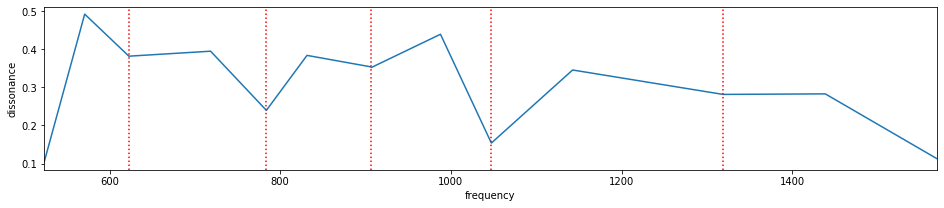

In [240]:

freqs = d
#freqs = freq_space(430, 3, 50)
plot_dissonance_curve(freqs, dissonance_curve(freqs, n_partials=250, model='sethares1993'))

# PyTuning

In [15]:
import pytuning as pt
import sympy as sp
from pytuning.scales import create_edo_scale
edo_12 = create_edo_scale(12)
edo_12


#x = pt.find_best_modes(harm_ratios[0], 7)
#x
#major_mask = (0,2,4,5,7,9,11,12)
#major_mode = mask_scale(edo_12_scale, major_mask)
#major_mode

In [26]:
x = pt.find_best_modes(charm_fit, 3)
x


[{'scale': [1.0357142857142856, 1.25, 1.294642857142857, 2.0],
  'mask': (0, 1, 2, 11),
  'steps': [1, 1, 9],
  'original_scale': [1.0357142857142856,
   1.25,
   1.294642857142857,
   1.3571428571428572,
   1.430921052631579,
   1.4736842105263157,
   1.5,
   1.526315789473684,
   1.8750000000000002,
   1.9078947368421053,
   1.9419642857142856,
   2.0],
  'sum_p_q': 9,
  'sum_distinct_intervals': 14,
  'metric_3': 36.3939393939395,
  'sum_p_q_for_all_intervals': 34,
  'sum_q_for_all_intervals': 14}]

In [90]:
#This function is similar to the harmonic_tuning function built in BioTuning Package

from pytuning.scales import create_harmonic_scale
scale = create_harmonic_scale(1,20)
scale

h, i = harmonic_tuning(12, 2)
h



[1.0, 2.0, 1.75, 1.5, 1.25, 1.125, 1.375]

In [ ]:
#Computes ratios of the harmonic scale

harm_ratios = compute_peak_ratios(h)
harm_ratios[0]

In [ ]:
h = EEG_harmonics_mult(peaks, 12, 0)
h

In [99]:
z = pt.scales.create_equal_interval_scale(3/2, scale_size=12)
z

[1.0,
 1.05349794238683,
 1.12500000000000,
 1.18518518518518,
 1.26562500000000,
 1.33333333333333,
 1.40466392318244,
 1.5,
 1.58024691358025,
 1.68750000000000,
 1.77777777777778,
 1.89843750000000,
 2]

In [111]:
sorted(ratios_tet)

[1.0136432647705078,
 1.06787109375,
 1.125,
 1.20135498046875,
 1.265625,
 1.3515243530273438,
 1.423828125,
 1.5,
 1.601806640625,
 1.6875,
 1.802032470703125,
 1.8984375]

In [49]:
intervals     = [22, 5, 9, 15]
multiplicities = [1,1,1,1]
scale         = pt.scales.create_euler_fokker_scale(intervals, multiplicities)
scale

NameError: name 'pt' is not defined

In [162]:
3/2**(1/9)

2.7776241368618715

## PyAudio

In [ ]:
def notes2play(array, fund):
    scale2play = []
    scale2play = [fund*x for x in array]
    
    return scale2play
    

In [74]:
import pyaudio
import struct
import math

FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()


def data_for_freq(frequency: float, time: float = None):
    """get frames for a fixed frequency for a specified time or
    number of frames, if frame_count is specified, the specified
    time is ignored"""
    frame_count = int(RATE * time)

    remainder_frames = frame_count % RATE
    wavedata = []

    for i in range(frame_count):
        a = RATE / frequency  # number of frames per wave
        b = i / a
        # explanation for b
        # considering one wave, what part of the wave should this be
        # if we graph the sine wave in a
        # displacement vs i graph for the particle
        # where 0 is the beginning of the sine wave and
        # 1 the end of the sine wave
        # which part is "i" is denoted by b
        # for clarity you might use
        # though this is redundant since math.sin is a looping function
        # b = b - int(b)

        c = b * (2 * math.pi)
        # explanation for c
        # now we map b to between 0 and 2*math.PI
        # since 0 - 2*PI, 2*PI - 4*PI, ...
        # are the repeating domains of the sin wave (so the decimal values will
        # also be mapped accordingly,
        # and the integral values will be multiplied
        # by 2*PI and since sin(n*2*PI) is zero where n is an integer)
        d = math.sin(c) * 32767
        e = int(d)
        wavedata.append(e)

    for i in range(remainder_frames):
        wavedata.append(0)

    number_of_bytes = str(len(wavedata))  
    wavedata = struct.pack(number_of_bytes + 'h', *wavedata)

    return wavedata


def play(frequency: float, time: float):
    """
    play a frequency for a fixed time!
    """
    frames = data_for_freq(frequency, time)
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, output=True)
    stream.write(frames)
    stream.stop_stream()
    stream.close()


#if __name__ == "__main__":
    
    
        


In [ ]:
scale2play = notes2play(d, 100)
scale2play
for i in scale2play:
    play(i, 1)
    